Rohlik Sales Forecasting Challenge (ARIMA, LGBMRegressor, RNN)

In this project, the goal is to tackle the Rohlik sales forecasting challenge, an online retailer scenario. The primary objective is to predict the daily sales volume for a set of specific products (unique_id) across various warehouses, taking into account historical, economic, and temporal factors that influence demand.

The prediction will be performed for the test dataset (sales_test.csv), using a model based on historical sales data and complementary features provided in the supplied files. The model's performance will be evaluated using a weighted metric based on the importance of each product (test_weights.csv).









In [1]:
#!pip install darts[torch] scikit-learn==1.2.2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.dataprocessing.transformers import Scaler


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Upload and Load Files

In [5]:
from google.colab import files
import pandas as pd

# Upload the files manually
uploaded = files.upload()


Saving sales_test.csv to sales_test.csv


In [6]:
# Load the data into pandas DataFrames
sales_train = pd.read_csv("sales_train_t.csv")
inventory = pd.read_csv("inventory.csv")
calendar = pd.read_csv("calendar.csv")
test_weights = pd.read_csv("test_weights.csv")
solution = pd.read_csv("solution.csv")
sales_test = pd.read_csv("sales_test.csv")


In [ ]:
# Load the data into pandas DataFrames
#sales_train = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_train.csv')
#inventory = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/inventory.csv')
#calendar = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/calendar.csv')
#test_weights = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/test_weights.csv')
#solution = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/solution.csv')


In [7]:
from IPython.display import display

# Display the first few rows of each file as tables
print("Sales Train Data:")
display(sales_train.head())

print("Inventory Data:")
display(inventory.head())

print("Calendar Data:")
display(calendar.head())

print("Test Weights Data:")
display(test_weights.head())


Sales Train Data:


,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0


Inventory Data:


,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
0,5255,2583,Pastry_196,Bakery,Bakery_L2_14,Bakery_L3_26,Bakery_L4_1,Prague_3
1,4948,2426,Herb_19,Fruit and vegetable,Fruit and vegetable_L2_30,Fruit and vegetable_L3_86,Fruit and vegetable_L4_1,Prague_3
2,2146,1079,Beet_2,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_65,Fruit and vegetable_L4_34,Prague_1
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1
4,4461,2197,Chicory_1,Fruit and vegetable,Fruit and vegetable_L2_17,Fruit and vegetable_L3_33,Fruit and vegetable_L4_1,Frankfurt_1


Calendar Data:


,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
0,2022-03-16,NaN,0,0,0,0,Frankfurt_1
1,2020-03-22,NaN,0,0,0,0,Frankfurt_1
2,2018-02-07,NaN,0,0,0,0,Frankfurt_1
3,2018-08-10,NaN,0,0,0,0,Frankfurt_1
4,2017-10-26,NaN,0,0,0,0,Prague_2


Test Weights Data:


,unique_id,weight
0,0,2.535369
1,1,3.888933
2,2,5.885237
3,3,2.139552
4,5,3.021715


## Data Analysis and Manipulation


In this part, we focus on understanding and preparing the datasets to be suitable for the predictive modeling task.
The sales_train.csv, calendar.csv, and inventory.csv datasets are the most relevant for predicting sales at the warehouse level.
The sales_train.csv file provides historical sales data, including key variables such as total_orders, sales, and sell_price_main, which are directly related to the target prediction.
In addition, calendar.csv contains valuable temporal information, such as holidays and school vacations, which can significantly affect sales patterns.
The inventory.csv file provides granular information about the inventory in the warehouses, as well as the name of the product in question as well as the categories to which it belongs.
We will also work with test_weights.csv which contains the weight associated with each product.

##Data Preprocessing

Several joins were performed between different data sets to combine relevant information. First, the sales set was combined with the inventory set using common columns as identifiers. Then, calendar information was added using columns such as warehouse and date. Finally, test weights data was added to the combined set using a unique identifier. The final result contains unified data from all these sources, preserving rows based on the join type specified at each step.

In [8]:
# Perform the merge using unique_id and warehouse
sales_train_inventory = pd.merge(
    sales_train,
    inventory,
    on=["unique_id", "warehouse"],
    how="inner"  # Change to "left", "right", or "outer" based on requirements
)

sales_train_inventory_calendar = pd.merge(
    sales_train_inventory,
    calendar,
    on=["warehouse", "date"],
    how="left"  # Use "left" to keep all rows from merged_data
)

final_combined_data = pd.merge(
    sales_train_inventory_calendar,
    test_weights,
    on="unique_id",
    how="left"  # Use "left" to keep all rows from final_data
)

# Display the first rows of the combined result
print(final_combined_data.columns)
print(final_combined_data.shape)
final_combined_data.head()


Index(['unique_id', 'date', 'warehouse', 'total_orders', 'sales',
       'sell_price_main', 'availability', 'type_0_discount', 'type_1_discount',
       'type_2_discount', 'type_3_discount', 'type_4_discount',
       'type_5_discount', 'type_6_discount', 'product_unique_id', 'name',
       'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en',
       'L4_category_name_en', 'holiday_name', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'weight'],
      dtype='object')
(1048575, 26)


,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,weight
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,...,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0,1.925596
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,...,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0,1.925596
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,...,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0,1.925596
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,...,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0,1.925596
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,...,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0,1.925596


The final dataset was sorted by the unique_id, date, and warehouse columns in ascending order. And also we check for duplicates based on unique_id, date, and warehouse

In [9]:
# Organize the final dataset by unique_id, date, and warehouse
final_combined_data = final_combined_data.sort_values(by=["product_unique_id", "date", "warehouse"])

# Check for duplicates based on unique_id, date, and warehouse
duplicates = final_combined_data.duplicated(subset=["product_unique_id", "date", "warehouse"])
if duplicates.any():
    print("Duplicates found:")
    print(final_combined_data[duplicates])
else:
    print("No duplicates found.")

# Check the first rows of the organized dataset
final_combined_data.head()

null_check = final_combined_data.isnull().sum()
print(null_check)

No duplicates found.
unique_id                       0
date                            0
warehouse                       0
total_orders                   19
sales                          19
sell_price_main                 0
availability                    0
type_0_discount                 0
type_1_discount                 0
type_2_discount                 0
type_3_discount                 0
type_4_discount                 0
type_5_discount                 0
type_6_discount                 0
product_unique_id               0
name                            0
L1_category_name_en             0
L2_category_name_en             0
L3_category_name_en             0
L4_category_name_en             0
holiday_name              1006378
holiday                         0
shops_closed                    0
winter_school_holidays          0
school_holidays                 0
weight                          0
dtype: int64


Check for nulls and zeros in the specified columns

In [10]:
# Check for nulls and zeros
print(final_combined_data[['total_orders', 'sales']].isnull().sum())
final_combined_data[['total_orders', 'sales']] = final_combined_data[['total_orders', 'sales']].fillna(0)


total_orders    19
sales           19
dtype: int64


In [12]:
print(final_combined_data[['total_orders', 'sales']].isnull().sum())

total_orders    0
sales           0
dtype: int64


Now we identify and display the data types of each column in the dataset.

In [11]:
# Get data types of each column
data_types = final_combined_data.dtypes

# Display the results
print(data_types)


unique_id                   int64
date                       object
warehouse                  object
total_orders              float64
sales                     float64
sell_price_main           float64
availability              float64
type_0_discount           float64
type_1_discount           float64
type_2_discount           float64
type_3_discount           float64
type_4_discount           float64
type_5_discount           float64
type_6_discount           float64
product_unique_id           int64
name                       object
L1_category_name_en        object
L2_category_name_en        object
L3_category_name_en        object
L4_category_name_en        object
holiday_name               object
holiday                     int64
shops_closed                int64
winter_school_holidays      int64
school_holidays             int64
weight                    float64
dtype: object


We will check whether all variables are necessary by examining the correlation of the independent variables with the target variable. This step is essential to ensure that we only use relevant features for the model and eliminate any redundant or irrelevant variables.


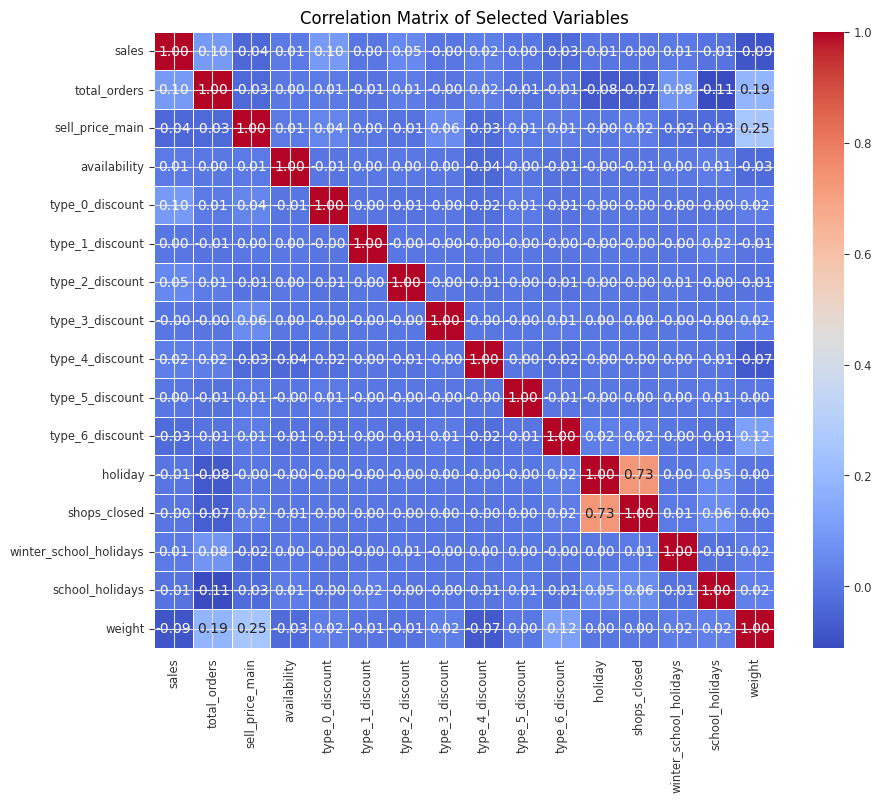

In [13]:
# Select the relevant columns
selected_columns = ['sales','total_orders', 'sell_price_main', 'availability',
                    'type_0_discount', 'type_1_discount', 'type_2_discount',
                    'type_3_discount', 'type_4_discount', 'type_5_discount',
                    'type_6_discount', 'holiday', 'shops_closed',
                    'winter_school_holidays', 'school_holidays', 'weight']

#Calculate the correlation matrix
correlation_matrix = final_combined_data[selected_columns].corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Selected Variables')
plt.show()

Conclusion of the analysis: the variables present little or insignificant correlations with the sales variables.
The ARIMA model is appropriate since no variables have been identified in the dataset that have a significant correlation with sales. ARIMA (Autoregressive Integrated Moving Average) is based on the historical values ​​of the target variable (sales, in this case) to model temporal patterns such as trends, seasonality and past dependencies. In this case we will apply it for monthly sales by Warehouse since applying it for each product is analyzing a historical series by product. Later, other algorithms will be applied to analyze sales by product.

#BASICS OF FORECASTING MODELS (ARIMA)

Building an ARIMA model requires extensive exploratory analysis. This critical step serves as a compass, guiding the analyst toward a detailed understanding of the intrinsic dynamics of the data. Before training an ARIMA model on a time series, it is important to perform exploratory analysis to determine, at a minimum, the following:


1. Stationarity: Stationarity means that statistical properties (mean, variance, etc.) remain constant over time, so time series with trends or seasonality are not stationary. Since ARIMA assumes stationarity of the data, it is essential to subject the data to rigorous testing, such as the Augmented Dickey-Fuller test, to assess that this is true. If non-stationarity is found, the series should be differenced until stationarity is achieved. This analysis helps determine the optimal value of the parameter d
2. Autocorrelation analysis: Plot the autocorrelation and partial autocorrelation functions (ACF and PACF) to identify possible lag relationships between values ​​in the series. This visual analysis helps determine the appropriate autoregressive (AR) and moving average (MA) terms ( p
and q) for the ARIMA model.

3. Seasonal decomposition: In cases where seasonality is suspected, decomposing the series into trend, seasonal, and residual components using techniques such as moving averages and seasonal time series decomposition (STL) can reveal hidden patterns and help identify seasonality. This analysis helps determine the optimal values ​​for the parameters P, D, Q, and m.

These exploratory analyses lay the foundation for beginning to build an effective ARIMA model that captures the fundamental patterns and associations within the data.



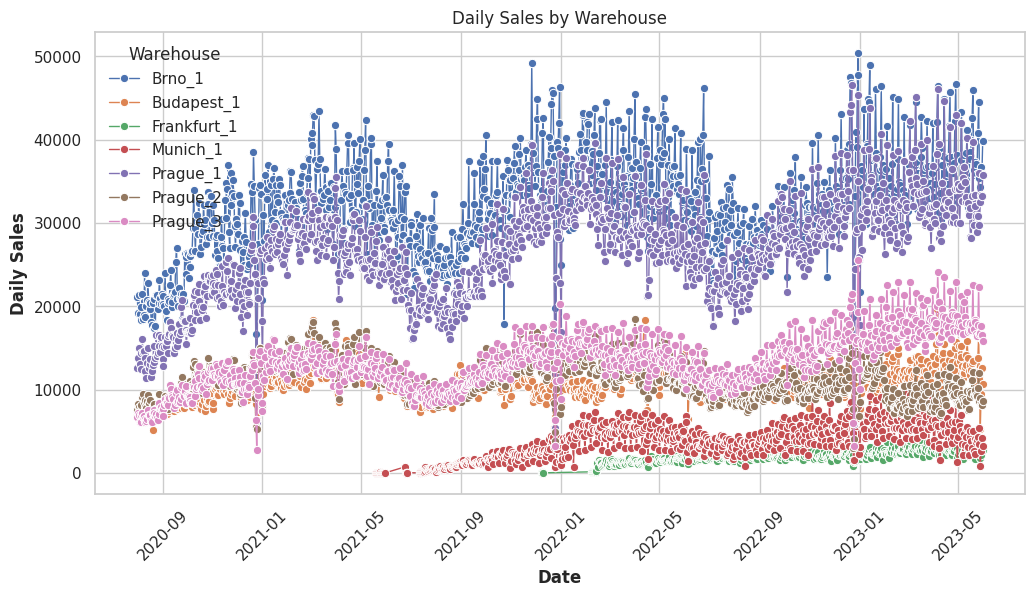

In [14]:
# Filter relevant columns
data_filtered = final_combined_data[['date', 'sales', 'warehouse']].copy()

# Convert 'date' to datetime format
data_filtered['date'] = pd.to_datetime(data_filtered['date'])

# Filter data up to May 31, 2023 (fixed incorrect year in your code)
data_filtered = data_filtered[data_filtered['date'] <= '2023-05-31']

# Group by warehouse and date (daily sales)
daily_sales_warehouse = data_filtered.groupby(
    ['warehouse', 'date']
)['sales'].sum().reset_index()

# Set seaborn style
sns.set(style="whitegrid")

# Create figure
plt.figure(figsize=(12, 6))

# Plot daily sales for each warehouse
sns.lineplot(
    data=daily_sales_warehouse,
    x='date',
    y='sales',
    hue='warehouse',
    marker="o",
    linewidth=1
)

# Set labels and title
plt.xlabel("Date")
plt.ylabel("Daily Sales")
plt.title("Daily Sales by Warehouse")  # Fixed title
plt.xticks(rotation=45)
plt.legend(title="Warehouse")
plt.grid(True)

# Show the plot
plt.show()

## Stationary
For ARIMA, the time series data should be stationary. You can check the stationarity using the Augmented Dickey-Fuller (ADF) test. If the p-value is less than 0.05, the data is stationary.
The KPSS test focuses on the presence of trends. A low p-value indicates non-stationarity due to a trend.
The graph generated in the previous section shows several negative and positive trends, indicating constant variation over time. As a result, the mean of the series increases and decreases over time.

Differencing to Achieve Stationarity: If the data is not stationary, you may need to difference it (subtract the previous value from the current value). This process can be repeated until the series becomes stationary.

The first difference is calculated as:

ΔXt=Xt−Xt−1

Where Xt is the value at time t and Xt−1 is the value at time t−1 . This is known as first-order differentiation. This process can be repeated if necessary until the desired stationarity is reached.

In [15]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*InterpolationWarning.*")

# Prepare a dictionary to store results ADF test
stationarity_results = {}

# Loop through each warehouse and perform for ADF test
for warehouse in daily_sales_warehouse['warehouse'].unique():
    # Filter the data for the warehouse
    warehouse_data = daily_sales_warehouse[daily_sales_warehouse['warehouse'] == warehouse]
    # Extract sales values
    sales_series = warehouse_data['sales']
    # Perform the ADF test
    adf_result = adfuller(sales_series)
    # Store the results for ADF test
    stationarity_results[warehouse] = {
        'ADF Statistic': adf_result[0],
        'ADF p-value': adf_result[1],
        'ADF Stationary': adf_result[1] < 0.05,  # Stationary if p-value < 0.05
    }
# Prepare a list to store the results
results_list = []

# Loop through each warehouse and perform ADF test
for warehouse, result in stationarity_results.items():
    # Create a dictionary for the current warehouse results
    results_list.append({
        'Warehouse': warehouse,
        'ADF Statistic': result['ADF Statistic'],
        'ADF p-value': result['ADF p-value'],
        'ADF Stationary': 'Yes' if result['ADF Stationary'] else 'No',
    })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results_list)

# Display the results table
print(results_df)



     Warehouse  ADF Statistic  ADF p-value ADF Stationary
0       Brno_1      -2.987213     0.036106            Yes
1   Budapest_1      -3.160113     0.022413            Yes
2  Frankfurt_1      -2.188729     0.210362             No
3     Munich_1      -2.283050     0.177493             No
4     Prague_1      -2.496738     0.116270             No
5     Prague_2      -2.927636     0.042227            Yes
6     Prague_3      -1.996145     0.288266             No


Most of the warehouses do not show stationarity according to the ADF test results. Specifically, Brno_1, Budapest_1, and Prague_2 are considered stationary, while Frankfurt_1, Munich_1, Prague_1, and Prague_3 are not. The corresponding p-values ​​are: Brno_1 (0.036106), Budapest_1 (0.022413), Frankfurt_1 (0.210362), Munich_1 (0.177493), Prague_1 (0.116270), Prague_2 (0.042227), and Prague_3 (0.288266).

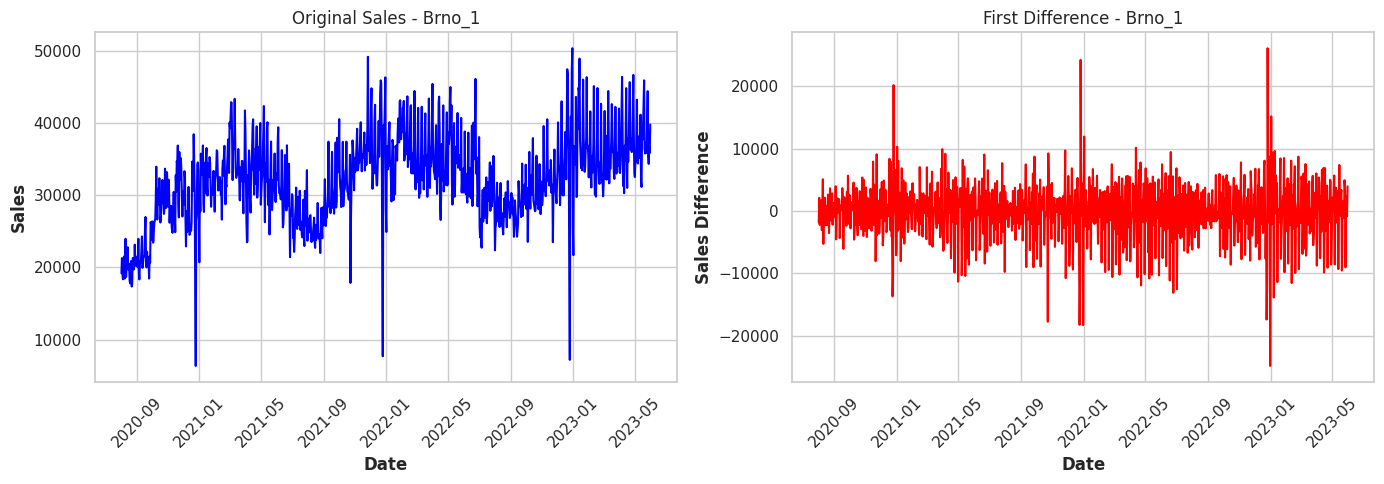

ADF Statistic: -9.6410
ADF p-value: 0.0000
Is the series stationary? Yes


In [16]:
# Filter and compute the first difference in one step
brno_1_diff = (
    daily_sales_warehouse[daily_sales_warehouse['warehouse'] == 'Brno_1']
    .copy()
    .assign(sales_diff=lambda df: df['sales'].diff())
    .dropna(subset=['sales_diff'])
)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Plot original sales
axes[0].plot(brno_1_diff['date'], brno_1_diff['sales'], color='blue')
axes[0].set_title("Original Sales - Brno_1")
axes[0].set_ylabel("Sales")

# Plot first difference of sales
axes[1].plot(brno_1_diff['date'], brno_1_diff['sales_diff'], color='red')
axes[1].set_title("First Difference - Brno_1")
axes[1].set_ylabel("Sales Difference")

# Formatting
for ax in axes:
    ax.set_xlabel("Date")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

plt.tight_layout()
plt.show()

# Perform ADF test
adf_stat, adf_pvalue, *_ = adfuller(brno_1_diff['sales_diff'])
print(f"ADF Statistic: {adf_stat:.4f}")
print(f"ADF p-value: {adf_pvalue:.4f}")
print(f"Is the series stationary? {'Yes' if adf_pvalue < 0.05 else 'No'}")



## ACF and PACF
The plot of the autocorrelation function (ACF) and partial autocorrelation function (PACF) of the time series provides useful information about possible suitable values ​​of p and q. The ACF helps to identify the value of q (lags in the moving average part), while the PACF helps to identify the value of p (lags in the autoregressive part).

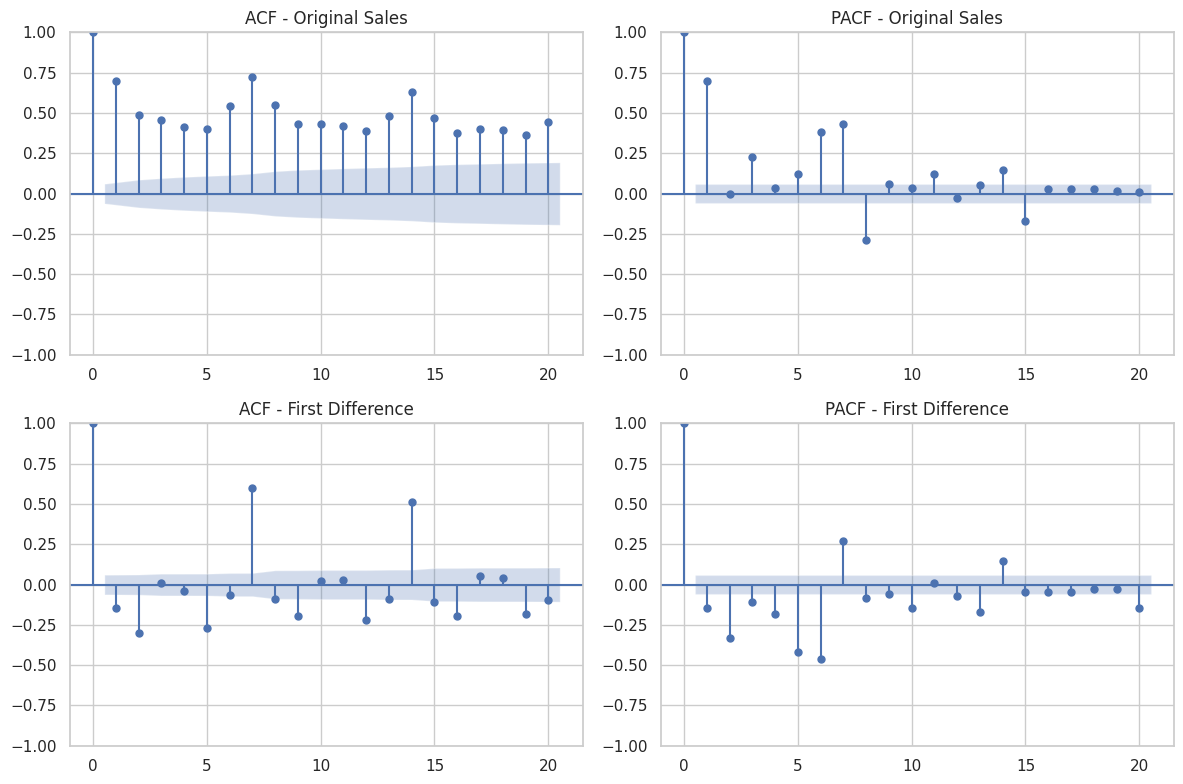

In [17]:


# Plot ACF and PACF for original and differenced series
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# ACF and PACF for original sales
plot_acf(brno_1_diff['sales'], lags=20, ax=ax[0, 0], title="ACF - Original Sales")
plot_pacf(brno_1_diff['sales'], lags=20, ax=ax[0, 1], title="PACF - Original Sales")

# ACF and PACF for first differenced sales
plot_acf(brno_1_diff['sales_diff'], lags=20, ax=ax[1, 0], title="ACF - First Difference")
plot_pacf(brno_1_diff['sales_diff'], lags=20, ax=ax[1, 1], title="PACF - First Difference")

plt.tight_layout()
plt.show()



## Analysis for Warehouse Brno_1 (Example)
We filter sales data for the period between the years 2021 and 2023, ensuring that there is enough data to perform a seasonal decomposition. The decomposition separates the time series into components such as trend, seasonality, and noise.

(881, 4)


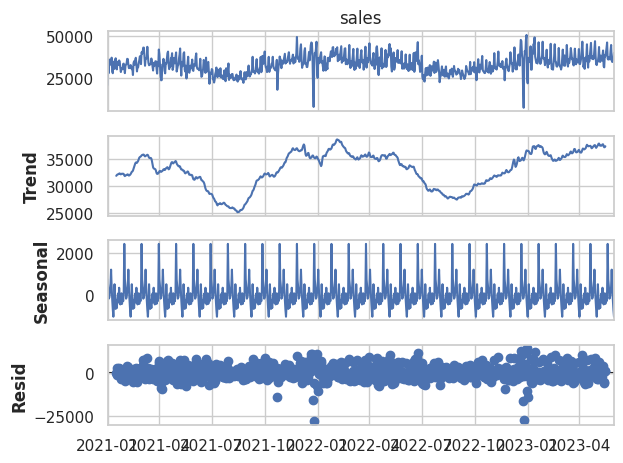

     warehouse       date     sales  sales_diff
153     Brno_1 2021-01-01  20719.08    -5689.07
154     Brno_1 2021-01-02  30993.30    10274.22
155     Brno_1 2021-01-03  27789.03    -3204.27
156     Brno_1 2021-01-04  35792.50     8003.47
157     Brno_1 2021-01-05  32877.21    -2915.29
...        ...        ...       ...         ...
1029    Brno_1 2023-05-27  35419.75    -9052.20
1030    Brno_1 2023-05-28  34371.75    -1048.00
1031    Brno_1 2023-05-29  36736.95     2365.20
1032    Brno_1 2023-05-30  35896.12     -840.83
1033    Brno_1 2023-05-31  39834.92     3938.80

[881 rows x 4 columns]


In [18]:
# Filter data for the years 2021 to 2023
brno_1_filtered = brno_1_diff[(brno_1_diff['date'] >= '2021-01-01') & (brno_1_diff['date'] <= '2023-12-31')]

# Ensure there are enough observations for decomposition
print(brno_1_filtered.shape)

# Perform seasonal decomposition with the adjusted period
brno_1_series = brno_1_filtered[['date', 'sales']].set_index('date')
result = seasonal_decompose(brno_1_series['sales'], model='additive', period=30)

# Plot the decomposition
result.plot()
plt.show()

print(brno_1_filtered)



In this code block, three ARIMA models with different parameter settings are fit to analyze sales time series. The ARIMA models are fit to capture patterns in the data and make predictions, using combinations of the parameters p (autoregressive), d (difference), and q (moving average). After each model is fit, a summary of the results for each model is printed, allowing you to compare their performance and determine which one best fits the sales data.

In [19]:
# Fit an ARIMA model
# Using p=1, d=1, q=1 as an example, but you can adjust based on ACF/PACF analysis
model_1_0_1 = ARIMA(brno_1_diff['sales'], order=(1, 0, 1))
model_1_0_1 = model_1_0_1.fit()

model_0_0_1 = ARIMA(brno_1_diff['sales'], order=(0, 0, 1))
model_0_0_1 = model_0_0_1.fit()

model_1_0_0 = ARIMA(brno_1_diff['sales'], order=(1, 0, 0))
model_1_0_0 = model_1_0_0.fit()


print(model_1_0_1.summary())
print(model_0_0_1.summary())
print(model_1_0_0.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1033
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -10090.728
Date:                Tue, 28 Jan 2025   AIC                          20189.457
Time:                        15:59:47   BIC                          20209.218
Sample:                             0   HQIC                         20196.955
                               - 1033                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.212e+04    437.114     73.486      0.000    3.13e+04     3.3e+04
ar.L1          0.6986      0.029     24.371      0.000       0.642       0.755
ma.L1          0.0104      0.041      0.255      0.7

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)



**AIC (Akaike Information Criterion):**
The lower AIC indicates a better balance between the model fit and its complexity.
- ARIMA(1,0,1) model: AIC = 20189.457
- ARIMA(0,0,1) model: AIC = 20346.449
- ARIMA(1,0,0) model: AIC = 20187.476

The ARIMA(1,1,1) model has the lowest AIC, so it is the preferred model according to this criterion.

**Goodness of fit (coefficients and significance):**
   * In the ARIMA(1,0,1) model: The AR (ar.L1) and MA (ma.L1) coefficients are statistically significant (p-value < 0.05).
   * In the ARIMA(0,0,1) model: The MA (ma.L1) coefficient is also significant (p-value < 0.05).
   * In the ARIMA(1,0,0) model: The AR coefficient (ar.L1) is significant (p-value < 0.05).

All models have significant parameters, but ARIMA(1,1,1) is more flexible by including both AR and MA components.

**Residuals (Ljung-Box and Jarque-Bera tests):**
Ljung-Box (L1) (Q):

   * ARIMA(1,01,1): Prob(Q) = 0.90 → There is no autocorrelation in the residuals.
   * ARIMA(0,0,1): Prob(Q) = 0.00 → There is autocorrelation in the residuals.
   * ARIMA(1,0,0): Prob(Q) = 0.99 → There is autocorrelation in the residuals.

ARIMA(1,0,1) and ARIMA(1,0,0) perform better in this test.

Jarque-Bera:
**bold text**
All models show residuals with normal distribution (p-value > 0.05), although ARIMA(1,0,0) has the best overall balance.
Conclusion:
The ARIMA(1,0,0) model is the best option considering

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


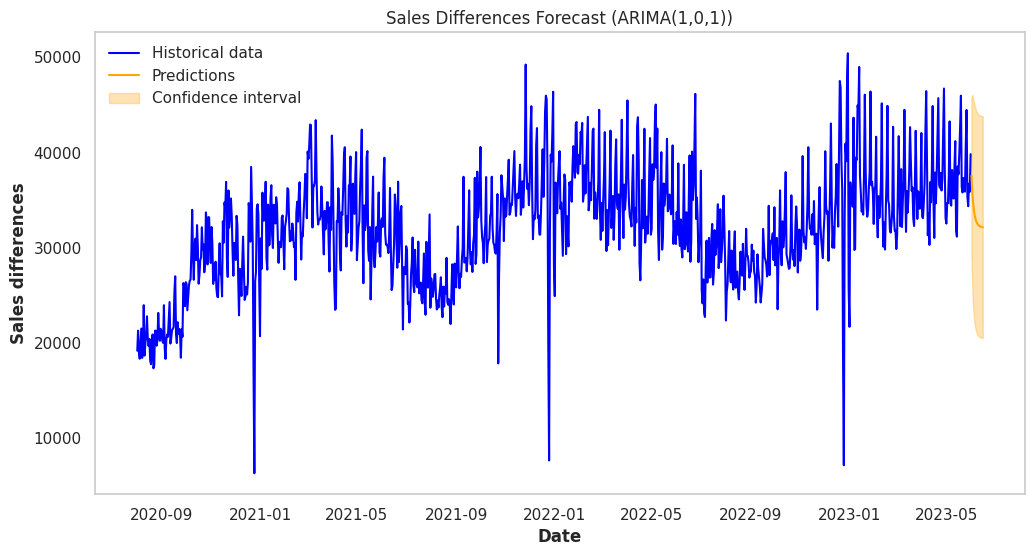

           date      forecast   lower_bound   upper_bound
1033 2023-06-01  37550.976034  29282.333664  45819.618403
1034 2023-06-02  35943.337725  25831.708276  46054.967174
1035 2023-06-03  34811.742130  23901.725945  45721.758314
1036 2023-06-04  34015.226779  22730.551131  45299.902428
1037 2023-06-05  33454.570034  21988.801350  44920.338718
1038 2023-06-06  33059.931078  21505.490057  44614.372100
1039 2023-06-07  32782.149875  21184.026690  44380.273060
1040 2023-06-08  32586.623316  20966.918342  44206.328290
1041 2023-06-09  32448.994727  20818.611745  44079.377709
1042 2023-06-10  32352.119762  20716.449918  43987.789605
1043 2023-06-11  32283.930740  20645.642374  43922.219105
1044 2023-06-12  32235.933378  20596.347866  43875.518890
1045 2023-06-13  32202.148663  20561.920524  43842.376801
1046 2023-06-14  32178.368043  20537.821524  43818.914562
1047 2023-06-15  32161.629176  20520.924916  43802.333435


In [20]:
# Load the dataset
data = brno_1_diff[['date', 'sales']]
brno_1 = pd.DataFrame(data)
brno_1['date'] = pd.to_datetime(brno_1['date'])
brno_1.set_index('date', inplace=True)

# Predictions for the next 12 months
n_steps = 15
forecast = model_1_0_0.get_forecast(steps=n_steps)
forecast_index = pd.date_range(brno_1.index[-1], periods=n_steps + 1, freq="D")[1:]
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(brno_1.index, brno_1['sales'], label="Historical data", color="blue")
plt.plot(forecast_index, forecast_values, label="Predictions", color="orange")
plt.fill_between(
    forecast_index,
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color="orange",
    alpha=0.3,
    label="Confidence interval"
)
plt.title("Sales Differences Forecast (ARIMA(1,0,1))")
plt.xlabel("Date")
plt.ylabel("Sales differences")
plt.legend()
plt.grid()
plt.show()

# Forecast results
forecast_df = pd.DataFrame({
    "date": forecast_index,
    "forecast": forecast_values,
    "lower_bound": confidence_intervals.iloc[:, 0],
    "upper_bound": confidence_intervals.iloc[:, 1]
})
print(forecast_df)



The data displays clear seasonality, with periodic peaks and troughs suggesting cyclical or seasonal trends in sales performance.
There is significant volatility, with occasional high peaks, particularly in late 2020, early 2021, and late 2022.

The forecast results for the next 15 days (from June 1, 2023, to June 15, 2023) indicate a gradual decline in predicted sales values. The forecast starts at 37,550.98 on June 1 and decreases to 32,161.63 on June 15. The confidence intervals widen over time, reflecting increased uncertainty as the forecast horizon extends. For instance, on June 1, the lower and upper bounds are 29,282.33 and 45,819.62, respectively, while on June 15, they range from 20,520.92 to 43,802.33. This suggests a general downward trend in sales with moderate uncertainty, consistent with the previous forecasted patterns.

# LGBMRegressor Model

The LGBMRegressor (LightGBM Regressor) is a model based on the Gradient Boosting algorithm, used for regression tasks, where continuous values ​​are predicted. This model is highly efficient in terms of speed and memory, making it suitable for working with large volumes of data. It uses decision trees that are trained sequentially to correct the errors of previous trees, and is able to directly handle categorical features without the need for additional coding. In addition, it offers various tuning parameters, such as the learning rate and depth of the trees, which allow optimizing its performance and avoiding overfitting.

Now we visualize the time series of sales of 4 products and We remove from our dataset the columns 'holiday name'

In [21]:
final_combined_data  = final_combined_data.drop(columns=['holiday_name'])

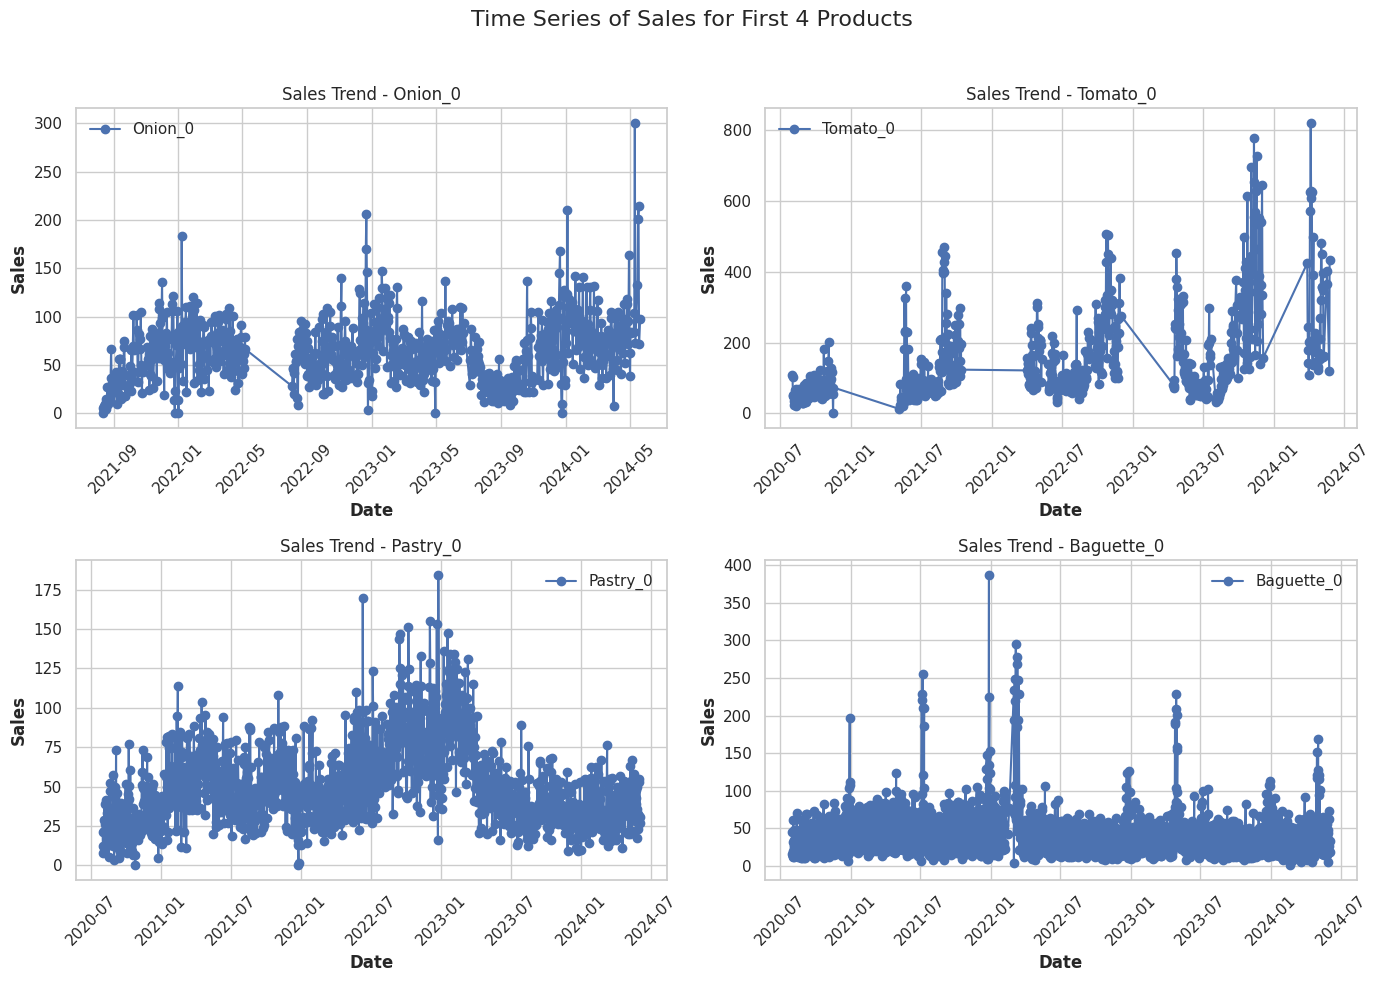

In [22]:
def plot_sales_by_product(df):
    # Convert the 'date' column to datetime type if it's not already
    df['date'] = pd.to_datetime(df['date'])

    # Get the first 4 unique products
    products = df['name'].unique()[:4]

    # Create a figure with subplots (2 rows, 2 columns)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Flatten to iterate more easily

    # Plot sales for each product
    for i, product in enumerate(products):
        product_data = df[df['name'] == product]

        ax = axes[i]
        ax.plot(product_data['date'], product_data['sales'], label=product, color='b', marker='o', linestyle='-')
        ax.set_title(f'Sales Trend - {product}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)

    # Remove extra axes if there are fewer than 4 products
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout and show plot
    plt.suptitle('Time Series of Sales for First 4 Products', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust spacing for the title
    plt.show()

# Call the function with your DataFrame
plot_sales_by_product(final_combined_data)


The model was trained using LightGBM (LGBMRessor) on the sales data, incorporating temporal and categorical features. During the training process, the model parameters were fine-tuned and optimized with the aim of minimizing the MAE. After fine-tuning, the model was evaluated on the test dataset, obtaining a MAE of 104.16

The Weighted Mean Absolute Error (WMAE) for the model is calculated as 36.23. This metric takes into account both the absolute prediction errors and the weights assigned to each observation.

In [65]:
# Convert 'date' to datetime format
final_combined_data['date'] = pd.to_datetime(final_combined_data['date'])

# Select relevant columns (only the necessary features)
df = final_combined_data[['unique_id', 'date', 'sales', 'warehouse', 'total_orders', 'sell_price_main',
                          'type_0_discount', 'type_1_discount', 'type_2_discount', 'type_3_discount',
                          'type_4_discount', 'type_5_discount', 'type_6_discount']].copy()

# Add temporal features
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_year'] = df['date'].dt.dayofyear

# Encode categorical columns
categorical_columns = ['warehouse']
df[categorical_columns] = df[categorical_columns].apply(lambda x: LabelEncoder().fit_transform(x))

# Split into training and testing sets
train_data = df[df['date'] < '2023-01-01']
test_data = df[(df['date'] >= '2023-01-01')]

# Define features (X) and target (y)
X_train, y_train = train_data.drop(columns=['sales', 'date']), train_data['sales']
X_test, y_test = test_data.drop(columns=['sales', 'date']), test_data['sales']

# Train the model
model_LGBM = lgb.LGBMRegressor(learning_rate=0.1, n_estimators=150, boosting_type='gbdt', metric='mae')
model_LGBM.fit(X_train, y_train)

# Predict and calculate MAE
y_pred = model_LGBM.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

# Display results
print(f'MAE: {mae}')

# Filter the data for dates >= '2023-01-01'
filtered_data = final_combined_data[final_combined_data['date'] >= '2023-01-01']

# Calculate absolute errors
absolute_errors = np.abs(y_test - y_pred)

# Ensure the length matches the filtered data
filtered_weights = filtered_data['weight'].values[:len(absolute_errors)]

# Compute WMAE
weighted_errors = filtered_weights * absolute_errors
wmae = weighted_errors.sum() / filtered_weights.sum()

# Display the result
print(f'WMAE: {wmae}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 614688, number of used features: 15
[LightGBM] [Info] Start training from score 135.307082
MAE: 104.15749073489803
WMAE: 85.37959191654858


In [24]:
# Ensure 'date' is in datetime format
predict_sales = sales_test
sales_test['date'] = pd.to_datetime(sales_test['date'])

# Sort the data by 'unique_id' and 'date'
#sales_test = sales_test.sort_values(by=['unique_id', 'date'])
#predict_sales = predict_sales.sort_values(by=['unique_id', 'date'])

# Add temporal features to sales_test
sales_test['day_of_week'] = sales_test['date'].dt.dayofweek
sales_test['month'] = sales_test['date'].dt.month
sales_test['year'] = sales_test['date'].dt.year
sales_test['day_of_year'] = sales_test['date'].dt.dayofyear

# Encode categorical columns
categorical_columns = ['warehouse']
sales_test[categorical_columns] = sales_test[categorical_columns].apply(lambda x: LabelEncoder().fit_transform(x))

# Drop 'date' columns for prediction
sales_test = sales_test.drop(columns=['date'])

# Predict using the trained LGBM model
y_pred = model_LGBM.predict(sales_test)

# Print the predictions
print(y_pred)




[210.206539   479.46753677 522.57504775 ... 172.46121143  37.20663798
  24.0395936 ]


In [25]:
# Add the predictions as a new column 'sales' in the weights_test_data dataframe
predict_sales['sales'] = y_pred

# Display the updated dataframe
print(predict_sales[['unique_id', 'date', 'sales']].head(20))

    unique_id       date       sales
0        1226 2024-06-03  210.206539
1        1226 2024-06-11  479.467537
2        1226 2024-06-13  522.575048
3        1226 2024-06-15  466.605237
4        1226 2024-06-09  201.273346
5        1226 2024-06-06  228.414125
6        1226 2024-06-12  479.467537
7        1226 2024-06-05  206.011395
8        1226 2024-06-04  206.660475
9        1226 2024-06-08  201.273346
10       1226 2024-06-07  232.432767
11       1226 2024-06-14  523.352091
12       1226 2024-06-16  466.605237
13       1226 2024-06-10  486.094241
14       5409 2024-06-08   47.223264
15       5409 2024-06-15   47.223264
16       5409 2024-06-12   47.495538
17       5409 2024-06-03   48.128428
18       5409 2024-06-09   47.223264
19       5409 2024-06-13   50.408875


In [26]:

# Create 'id' column by applying a function to concatenate 'unique_id' and 'date'
predict_sales['id'] = predict_sales.apply(lambda row: f"{row['unique_id']}_{pd.to_datetime(row['date']).strftime('%Y-%m-%d')}", axis=1)

# Rename the 'sales' column to 'sales_hat'
predict_sales = predict_sales.rename(columns={'sales': 'sales_hat'})

# Select 'id' and 'sales_hat' columns and save as CSV
predict_sales[['id', 'sales_hat']].to_csv('submission.csv', index=False)

We prepared the dataset to estimate sales for the month of June 2024 for each product, with the built model.  As we are talking about time series, they can show repetitive behaviors year after year, but it cannot always be assumed that the future will be exactly the same as the past due to possible changes in the business environment or the market.


#BlockRNNModel

The BlockRNNModel is a time series model from the Darts library that uses Recurrent Neural Networks (RNNs), such as LSTM, GRU, or standard RNN, to learn sequential patterns in data. It works with a window-based approach, where it uses a fixed number of previous steps (input_chunk_length) to predict multiple future values ​​(output_chunk_length). It is highly customizable, with parameters such as dropout, n_epochs, and batch_size, and allows working with multiple related time series.

Now we filter the data by each product, select the date and sales columns, and group the sales by date, adding them up for each product. The processed results for each product are stored in a dictionary, where the key is the product name and the value is a DataFrame with the date and sales grouped by each day.

In [27]:
# Group by 'name' and 'date', and sum 'sales' once
productos = final_combined_data.groupby(['name', 'date'], as_index=False)['sales'].sum()

# Dictionary to store processed data for each product
product_data = {}

# Filter and store the grouped data for each product
for product in productos['name'].unique():
    # Filter data for the current product
    product_data[product] = productos[productos['name'] == product][['date', 'sales']]

# Optionally, check the processed data for one product (e.g., the first one)
print(productos['name'].unique())


['Apple_107' 'Apple_109' 'Apple_119' 'Apple_124' 'Apple_132' 'Apple_19'
 'Apple_21' 'Apple_29' 'Apple_3' 'Apple_42' 'Apple_43' 'Apple_49'
 'Apple_6' 'Apple_69' 'Apple_7' 'Apple_72' 'Apple_86' 'Apple_95'
 'Apple_96' 'Apricot_11' 'Apricot_13' 'Arugula_1' 'Arugula_10' 'Arugula_5'
 'Arugula_9' 'Asparagus_0' 'Asparagus_13' 'Asparagus_14' 'Asparagus_5'
 'Avocado_12' 'Avocado_14' 'Avocado_15' 'Avocado_2' 'Avocado_3'
 'Avocado_5' 'Avocado_6' 'Avocado_7' 'Bag_0' 'Bag_1' 'Bagel_1' 'Bagel_4'
 'Bagel_6' 'Bagel_7' 'Bagel_8' 'Baguette_0' 'Baguette_10' 'Baguette_12'
 'Baguette_13' 'Baguette_14' 'Baguette_15' 'Baguette_17' 'Baguette_25'
 'Baguette_26' 'Baguette_3' 'Baguette_30' 'Baguette_31' 'Baguette_32'
 'Baguette_4' 'Baguette_40' 'Baguette_6' 'Baguette_7' 'Baguette_9'
 'Bakery_0' 'Banana_0' 'Banana_1' 'Banana_10' 'Banana_2' 'Banana_6'
 'Banana_7' 'Banana_8' 'Basil_2' 'Basil_4' 'Basil_5' 'Bean_2' 'Beef_1'
 'Beef_10' 'Beef_12' 'Beef_13' 'Beef_17' 'Beef_19' 'Beef_20' 'Beef_22'
 'Beef_24' 'Beef_28' 'Be

We use the Croissant 9 example product to make the prediction for the months of June 2024

In [59]:
Croissant_9 = product_data['Croissant_9']
print(Croissant_9.head(6))

             date  sales
327253 2020-08-01   0.00
327254 2020-08-02  15.44
327255 2020-08-03   7.34
327256 2020-08-04   5.91
327257 2020-08-05   1.51
327258 2020-08-06   0.00


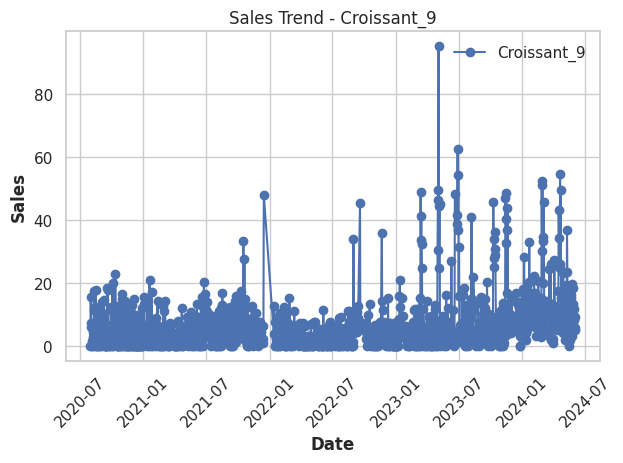

In [60]:
Croissant_9['date'] = pd.to_datetime(Croissant_9['date'])
fig, ax = plt.subplots()
ax.plot(Croissant_9['date'], Croissant_9['sales'], label='Croissant_9', color='b', marker='o', linestyle='-')
ax.set_title(f'Sales Trend - {"Croissant_9"}')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.xticks(rotation=45)  # Optional: Rotate date labels for better readability
plt.tight_layout()      # Optional: To prevent clipping of labels
plt.show()

This code handles sales data for a specific product, in this case, "Croissant_9", and fills in any missing dates in the date range of the time series. First, it sorts the data by date and generates a complete date range from the first to the last available day in the data. Then, it identifies the missing dates in the data and, for each missing date, adds a row with the sales from the previous day. Afterwards, it concatenates the missing rows with the original data, making sure that the dataset is sorted by date. Finally, the updated dataset is displayed with the missing dates added.

In [41]:

# Assuming 'product_data' is a dictionary with product names and their corresponding data
df = product_data['Croissant_9']

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Initialize an empty list to store rows to be added
rows_to_add = []

# Ensure the DataFrame is sorted by date
df = df.sort_values(by='date')

# Generate the complete date range from the first to the last date in the dataset
full_date_range = pd.date_range(df['date'].min(), df['date'].max(), freq='D')

# Identify missing dates
missing_dates = set(full_date_range) - set(df['date'])

# Only proceed if there are missing dates
if missing_dates:
    # For each missing date, add a row with sales from the previous day
    for missing_date in sorted(missing_dates):
        # Get the data from the previous day
        previous_day_data = df[df['date'] < missing_date].iloc[-1].to_dict()

        # Update the date to the missing date
        previous_day_data['date'] = missing_date

        # Add the new row to the list of rows to be added
        rows_to_add.append(previous_day_data)

    # Create a DataFrame with the new rows and append it to the original dataset
    new_rows_df = pd.DataFrame(rows_to_add)
    df = pd.concat([df, new_rows_df], ignore_index=True)

    # Reorder the dataset by date
    df = df.sort_values(by="date").reset_index(drop=True)

# Print the updated DataFrame with the missing dates inserted (if any)
print(df.head())


           date  sales
1397 2024-05-29   6.09
1398 2024-05-30  11.80
1399 2024-05-31   5.82
1400 2024-06-01   9.07
1401 2024-06-02   5.08


This code processes sales data for the product "Croissant_9" and fills in any missing dates within the available time series. It first sorts the data by date and generates a complete date range from the first to the last recorded day. Then, it identifies the missing dates and, for each one, inserts a new row with sales set to 0. After adding these rows, the function merges them with the original dataset and ensures that the data remains sorted by date. Finally, the updated dataset, now including the previously missing dates with sales recorded as 0, is displayed.

In [61]:
# Assuming 'product_data' is a dictionary with product names and their corresponding data
df = product_data['Croissant_9']

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Ensure the DataFrame is sorted by date
df = df.sort_values(by='date')

# Generate the complete date range from the first to the last date in the dataset
full_date_range = pd.date_range(df['date'].min(), df['date'].max(), freq='D')

# Identify missing dates
missing_dates = set(full_date_range) - set(df['date'])

# Initialize an empty list to store rows to be added
rows_to_add = []

# For each missing date, add a row with sales set to 0
for missing_date in sorted(missing_dates):
    rows_to_add.append({'date': missing_date, 'sales': 0})

# Create a DataFrame with the new rows and append it to the original dataset
if rows_to_add:
    new_rows_df = pd.DataFrame(rows_to_add)
    df = pd.concat([df, new_rows_df], ignore_index=True)

# Reorder the dataset by date
df = df.sort_values(by="date").reset_index(drop=True)

# Print the updated DataFrame with the missing dates inserted
print(df.tail())


           date  sales
1397 2024-05-29   6.09
1398 2024-05-30  11.80
1399 2024-05-31   5.82
1400 2024-06-01   9.07
1401 2024-06-02   5.08


The next function trains a BlockRNNModel with customizable parameters for input and output lengths, architecture type, and hyperparameters. It splits the data into training and validation sets, normalizes the data, fits the model, forecasts the future, and evaluates the results with RMSE, providing a visualization of the forecast and its performance.

In [63]:
from darts.metrics import mae
# Define a function to train and forecast using the BlockRNNModel
def train_and_forecast(
    data,
    name,
    input_chunk_length,  # Number of past time steps used as input for the model
    output_chunk_length, # Number of future time steps to predict
    model_type,          # Underlying architecture (LSTM/GRU/RNN)
    random_state,        # Seed for reproducibility
    n_epochs,            # Number of training epochs
    batch_size,          # Batch size for training
    dropout,             # Dropout rate for regularization
    lr,                  # Learning rate for the optimizer
    activation           # Activation function (e.g., 'relu', 'tanh')
):
    # Ensure the data does not contain null values
    data = pd.DataFrame(data)
    data['date'] = pd.to_datetime(data['date'])

    # Convert the series into a TimeSeries object
    ts = TimeSeries.from_dataframe(data, "date", "sales", freq='D')

    # Normalize the series (optional, improves training stability)
    scaler = Scaler()
    ts = scaler.fit_transform(ts)

    # Split the series into training and validation sets
    train, val = ts.split_after(pd.Timestamp("2024-04-30"))

    # Train the BlockRNNModel with dynamic parameters
    model = BlockRNNModel(
        input_chunk_length=input_chunk_length,  # Number of past time steps used for input
        output_chunk_length=output_chunk_length,  # Number of future time steps to predict
        model=model_type,           # Architecture: LSTM (Long Short-Term Memory), GRU, or RNN
        random_state=random_state,  # Seed for reproducibility
        n_epochs=n_epochs,          # Total number of training epochs
        batch_size=batch_size,      # Number of samples per training batch
        dropout=dropout,            # Dropout rate for regularization to prevent overfitting
        optimizer_kwargs={"lr": lr}, # Learning rate for the optimizer
        activation=activation,        # Activation function to apply in the model
        n_rnn_layers=3
    )

    # Train the model on the training data
    model.fit(train)

    # Inverse transform the training and validation sets
    train = scaler.inverse_transform(train)
    val = scaler.inverse_transform(val)

    # Forecast the future for the specified prediction horizon
    forecast = model.predict(n=output_chunk_length, series=train)

    # Inverse transform the forecasted values
    forecast = scaler.inverse_transform(forecast)

    # Generate the dates for the forecasted values
    forecast_dates = pd.date_range(start=train.time_index[-1] + pd.Timedelta(days=1), periods=output_chunk_length, freq='D')

    # Convert the forecasted values into a DataFrame
    forecast_df = pd.DataFrame({
        'date': forecast_dates,
        'sales': forecast.values().flatten()
    })

    # Calculate RMSE for evaluation
    mae_value = mae(val, forecast)
    print(f"MAE for {name}: {mae_value:.2f}")

    # Plot the training, validation, and forecasted values
    plt.figure(figsize=(12, 6))
    train.plot(label=f"Train {name}", color="blue")
    val.plot(label=f"Validation {name}", color="orange")
    forecast.plot(label=f"Forecast {name}", color="green", linestyle="--")
    plt.title(f"Forecast for {name}")
    plt.legend()
    plt.show()

    # Return the forecast as a DataFrame
    return forecast_df


In this code, an LSTM model is set up to predict the sales of “Croissant_9” using data from the past 365 days as input and generating forecasts for the next 60 days. The model is trained for 200 epochs with a batch size of 128, using a learning rate of 0.1. A 50% dropout rate is applied to regularize the model and avoid overfitting. The chosen activation function is ReLU, and the random seed is set to 42 to ensure reproducibility of the results. This set of parameters seeks to optimize the accuracy of the model while controlling the training complexity.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 13.2 K | train
6 | fc              | Sequential       | 1.6 K  | train
-------------------------------------------------------------
14.8 K    Trainable params
0         Non-trainable p

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

MAE for Croissant_9: 6.69


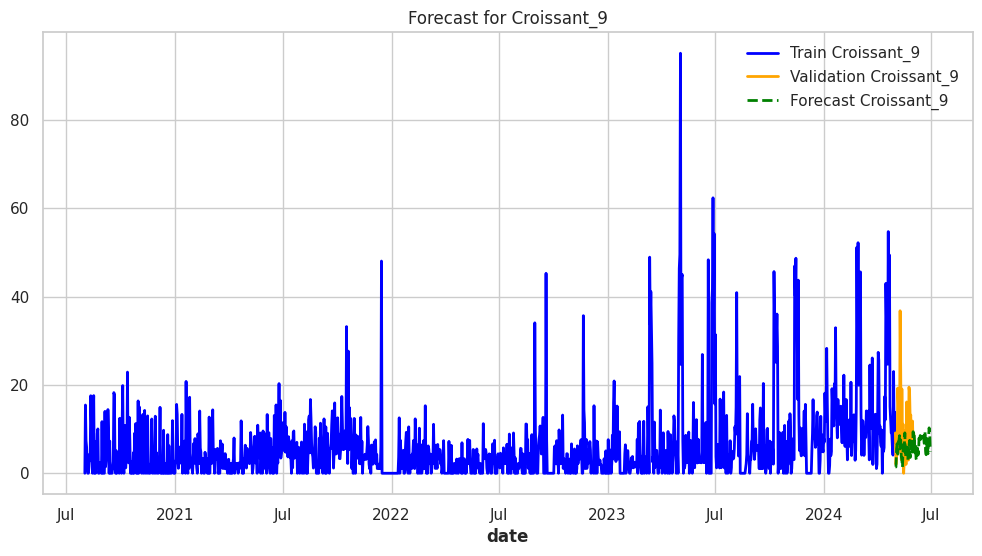

         date      sales
0  2024-05-01   1.390021
1  2024-05-02   1.424672
2  2024-05-03   5.526627
3  2024-05-04   6.684996
4  2024-05-05   4.343094
5  2024-05-06   7.167420
6  2024-05-07   7.298439
7  2024-05-08   8.509990
8  2024-05-09   5.498704
9  2024-05-10   7.553491
10 2024-05-11   3.845195
11 2024-05-12   2.950643
12 2024-05-13   1.369896
13 2024-05-14   5.389403
14 2024-05-15   6.579748
15 2024-05-16   4.983368
16 2024-05-17   9.139123
17 2024-05-18   3.658224
18 2024-05-19   4.969132
19 2024-05-20   4.953818
20 2024-05-21   6.652065
21 2024-05-22   2.974787
22 2024-05-23   6.009362
23 2024-05-24   6.133114
24 2024-05-25   7.424945
25 2024-05-26   3.566891
26 2024-05-27   7.667436
27 2024-05-28   6.076859
28 2024-05-29   6.826023
29 2024-05-30   4.784561
30 2024-05-31   9.402466
31 2024-06-01   6.312615
32 2024-06-02   8.477451
33 2024-06-03   4.614933
34 2024-06-04   6.392854
35 2024-06-05   3.286805
36 2024-06-06   2.896072
37 2024-06-07   6.355409
38 2024-06-08   4.610580


In [64]:
Croissant_9 = df
# Apply the function to each of the series and save the predictions
forecast_Croissant_9 = train_and_forecast(
    data=Croissant_9,
    name="Croissant_9",
    input_chunk_length=365,
    output_chunk_length=60,
    model_type="LSTM",
    random_state=42,
    n_epochs=100,
    batch_size=32,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

print(forecast_Croissant_9)

# Conclusion

Initially, when using LGBMRegressor to predict sales, it was observed that the independent variables included in the model did not show significant correlations with sales in the correlation analysis. This meant that the chosen variables did not provide relevant information for the prediction, leading to a high error in the estimates, since LightGBM's decision trees tried to fit a pattern that did not actually exist.

For this reason, it was decided to use BlockRNNModel, an approach based on Recurrent Neural Networks (RNN). This change in strategy allowed sales to be modeled based on their history, instead of depending on unimportant external variables. Since sales usually have a strong temporal dependence with seasonal patterns and trends, the use of past sequences as input for the prediction turned out to be a better strategy.

What we can add is that it would be more time-consuming since each series has to be analyzed by product and the parameters adjusted according to each series.